In [74]:
from analysis import process_text
import matplotlib.pyplot as plt
import pandas as pd

In [98]:
df1 = process_text('measures.txt')
df = df1.groupby(['datapoints', 'epoch']).mean().drop('experiment', axis=1).reset_index()

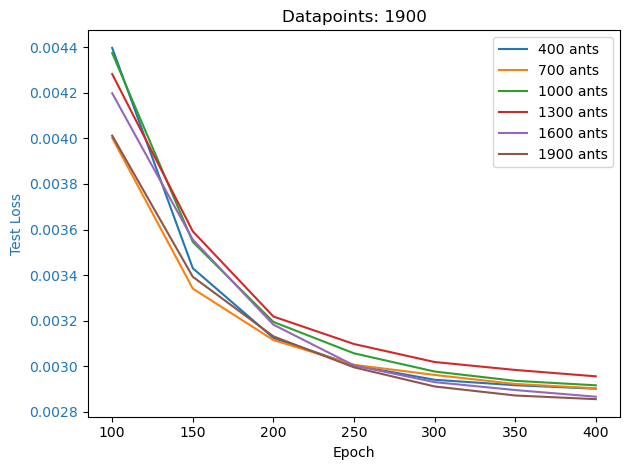

In [106]:
unique_datapoints = df["datapoints"].unique()

fig, ax1 = plt.subplots()
ax1.set_xlabel("Epoch")
i=0

for datapoint in unique_datapoints:
    subset = df[df["datapoints"] == datapoint].iloc[2:]

    # Plot test_loss on primary y-axis
    ax1.set_ylabel("Test Loss", color="tab:blue")
    ax1.plot(subset["epoch"], subset["test_loss"], label=f"{unique_datapoints[i]} ants")
    i = i+1
    
ax1.tick_params(axis="y", labelcolor="tab:blue")
# Title and layout
plt.title(f"Datapoints: {datapoint}")
plt.legend()
fig.tight_layout()
plt.show()


In [103]:
unique_datapoints

array([ 400,  700, 1000, 1300, 1600, 1900])